In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from collections import namedtuple

import pandas as pd
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.evaluation import *
from ipynb.fs.full.Data_Processing import *
from sklearn.model_selection import KFold
import time

### Baseline classification performance on EEG Dataset

Get with 5 fold cross-validation and performance on the test set
- Load the data of each user for all tests 
- Get performance per user - attention, interest, effort
- Get performance per user 

### 1) Load the data

In [2]:
def average(lst): 
    return sum(lst) / len(lst) 

In [3]:
def choose_base_model(model_type, objective):
    # choose model
    if model_type == 'clf':
        model = LGBMClassifier(objective=objective,num_leaves=31, learning_rate=0.1, random_state=5)
        return model
    else: 
        model = LGBMRegressor(num_leaves=31, learning_rate=0.1, random_state=5)
        return model

def choose_obj(num_classes):
    if num_classes == 2:
        objective = 'binary'
        return objective
    else: 
        objective = 'multiclass' 
        return objective

In [4]:
def kfold_predict(X,y, model_type):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    
    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}
        
    total_predictions = []
    total_true = []
    num_classes = 0
    for train_index, test_index in kf.split(X):

        #Train/test split
        X_train, X_test = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_test = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        total_true.append(y_test)
        size = len(X_train) + len(X_test)
        
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))
        objective = choose_obj(num_classes)           
        model = choose_base_model(model_type, objective).fit(X_train,y_train)
        y_pred = model.predict(X_test)
        total_predictions.append(y_pred)
        r = get_results(y_test, y_pred, model_type) # get dictionary of all results
        
        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])

    for key in results: # average out the results 
        results[key] = average(results[key])

    return results, np.concatenate(total_predictions), np.concatenate(total_true) , num_classes , size

In [5]:
def get_results_per_user(all_users, users, results, labels , bandpass, model_type):
    """
    Method for getting results per user by applying 5 fold cross validation.
    """
    for user in users:
        print("Running User {0}".format(user))

        for label in labels:
            time_start = time.time()
            test_list = all_users[user] # list of all the tests
            if bandpass == True:
                X = np.array([np.array(filter_df(test.iloc[:,:8])) for test in test_list]) # filtered array of all the inputs for each test
            else:
                X = np.array([np.array(test.iloc[:,:8]) for test in test_list]) # array of all the inputs for each test
            y = np.array([np.array(test[label]) for test in test_list]) # array of given labels for each test           

            # get results
            r, y_pred, y_true, num_classes, size = kfold_predict(X,y, model_type)
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs=None, window_size_samples=None))

            if model_type == 'clf':
                # plot confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                saved_file = "results/baseline/clf/confusion matrices/k_fold_performance/LGBM_User_{0}_{1}.png".format(user,label)
                plot_confusion_matrix(cm, set(y_true), normalize=True , file = saved_file)
            if model_type == 'reg':
                saved_file = "results/baseline/reg/y vs y_pred/per user/LGBM_User_{0}_{1}.png".format(user,label)
                plot_model(y_true, y_pred, user, label,file=saved_file)
              

In [6]:
def get_results_cross_users(labels, all_users_agg, results, bandpass, model_type):
    """
    Method for getting results cross-user using 5-Fold cross-validation
    """
    user = 'cross'
    # get the results cross-user
    for label in labels: #put the inputs and labels in an array for K-fold
        time_start = time.time()
        if bandpass == True: # filter the channels using bandpass filtering
            X = np.array([np.array(filter_df(all_users_agg[key].iloc[:, :8] )) for key in all_users_agg]) #array of aggregated inputs per user
        else:
            X = np.array([np.array(all_users_agg[key].iloc[:, :8] ) for key in all_users_agg])
        y = np.array([np.array(all_users_agg[key][label]) for key in all_users_agg]) # array of aggregated labels per user        

        # get results 
        r, y_pred, y_true, num_classes , size = kfold_predict(X,y, model_type)
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs=None, window_size_samples=None))

        if model_type == 'clf':
            # plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            saved_file = "results/baseline/clf/confusion matrices/k_fold_performance/LGBM_User_{0}_{1}.png".format('all',label)
            plot_confusion_matrix(cm, set(y_true), normalize=True , file = saved_file)
            
        if model_type == 'reg':
                saved_file = "results/baseline/reg/y vs y_pred/cross user/LGBM_User_{0}_{1}.png".format(user,label)
                plot_model(y_true, y_pred, user, label,file=saved_file)

In [7]:
def get_all_results(model_type, result_type):
    """
    Method for getting all results per user and across users by applying 5 fold cross validation.
    """
    # Load all the data
    per_user_path = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_tests_EEG_no_agg.pickle"
    all_user_path = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_tests_EEG.pickle"
    all_users_no_agg = load_file(per_user_path) # dictionary of all users , where tests are split out by user without aggregation for per user analysis
    all_users_agg = load_file(all_user_path) # dictionary of all users, where tests are aggregated by user for cross-user analysis
    
    users = all_users_no_agg.keys()
    results = []
    labels = ['attention','interest','effort']
    order = 4
    time_start = time.time()
    
    if result_type == 'per user':
        # get the results per user
        get_results_per_user(all_users_no_agg, users, results, labels, True, model_type)
    else:
        #get results cross user
        get_results_cross_users(labels, all_users_agg, results , True,  model_type)

  
    results  = pd.DataFrame(results).to_csv("results/baseline/{0}/tabulated/k fold/LGBM_5_fold_CV_performance_{1}_bandpass.csv".format(model_type, result_type), index=False)

    print("Time elapsed! {0}".format(time.time() - time_start))
    return results

Running User 1
Running User 2
Running User 3
Running User 6


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 7


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 8


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 9


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 10


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 11


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 12


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 17


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 18


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 19


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 20


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 22


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 23


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 24


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Running User 25


ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:127: RuntimeWarning: More than 20 figures have been opened. Figures created th

Time elapsed! 117.58702898025513


<Figure size 432x288 with 0 Axes>

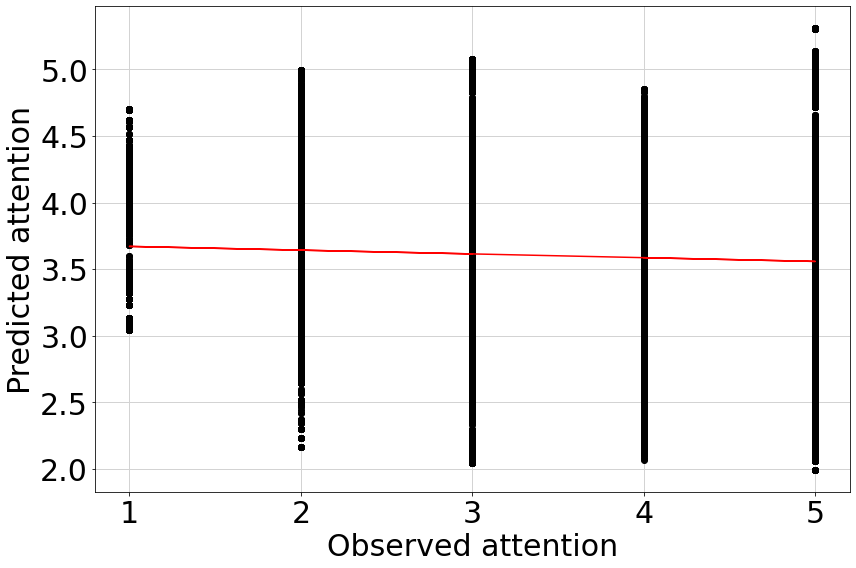

<Figure size 864x576 with 0 Axes>

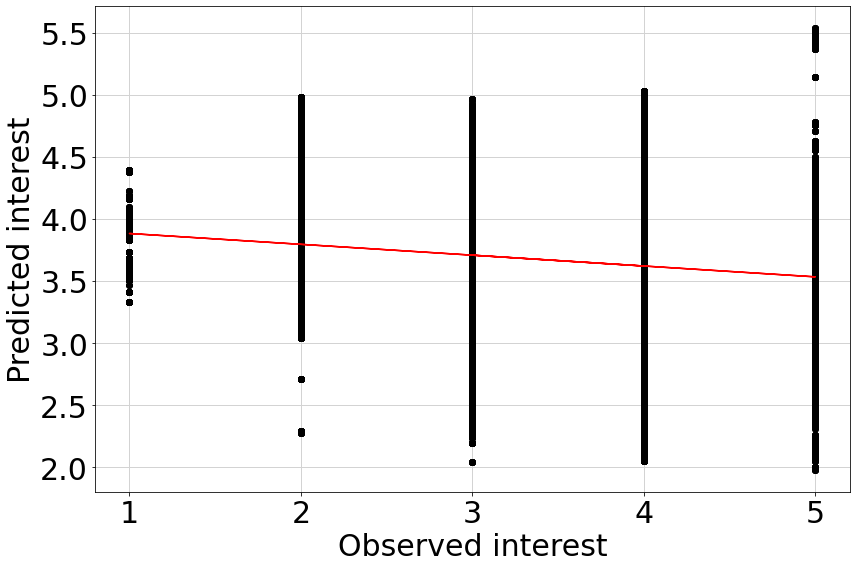

<Figure size 864x576 with 0 Axes>

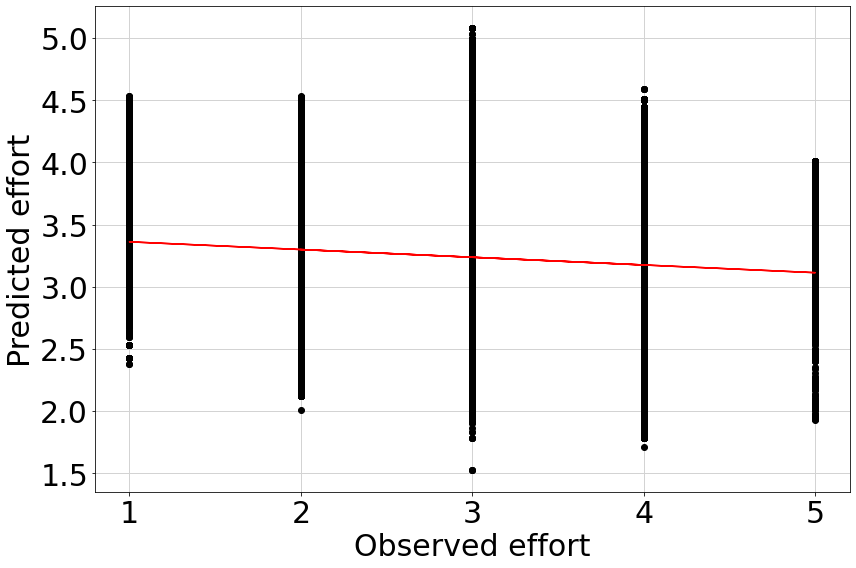

<Figure size 864x576 with 0 Axes>

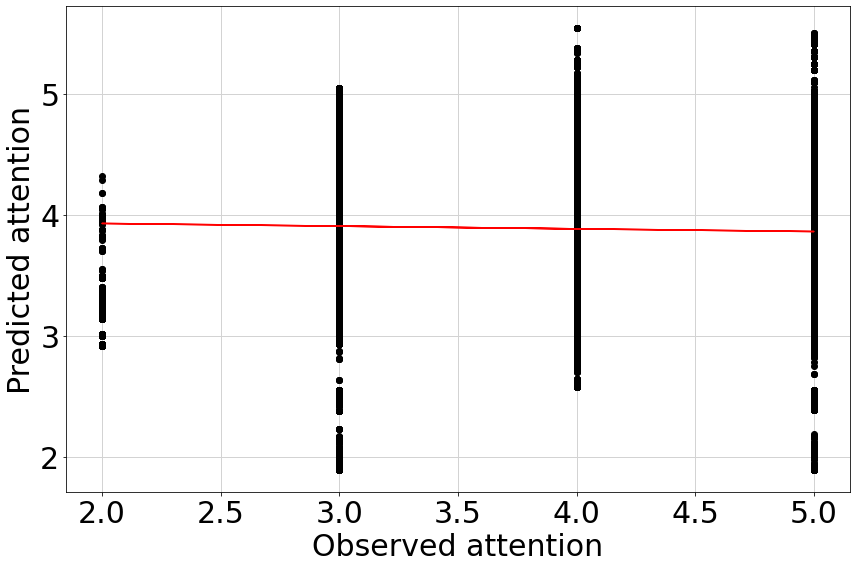

<Figure size 864x576 with 0 Axes>

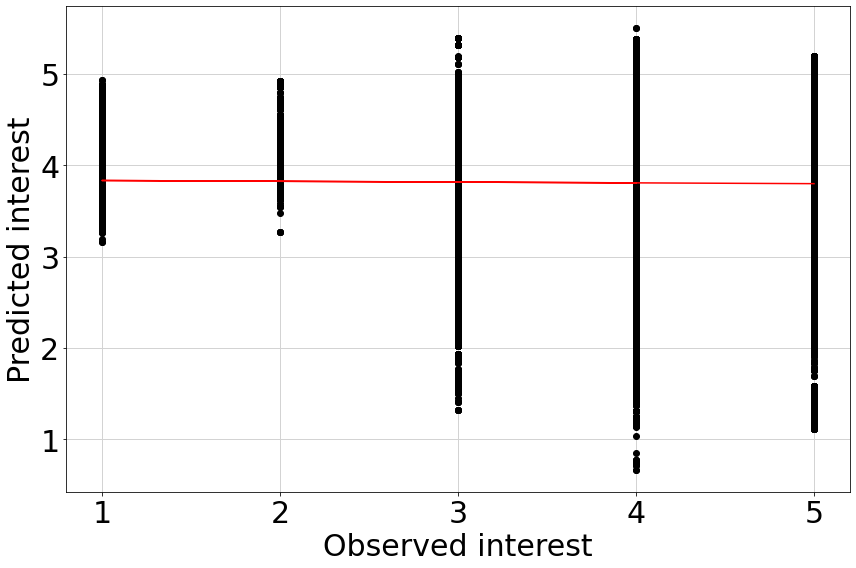

<Figure size 864x576 with 0 Axes>

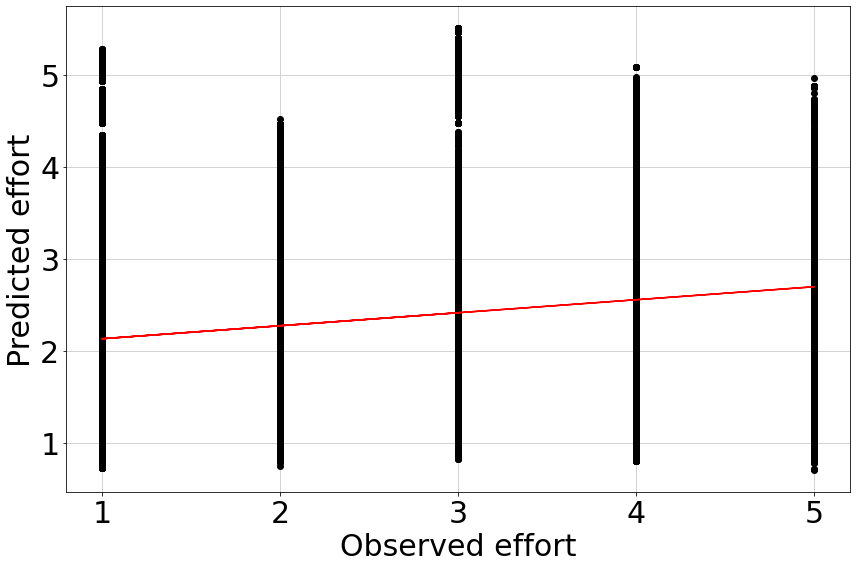

<Figure size 864x576 with 0 Axes>

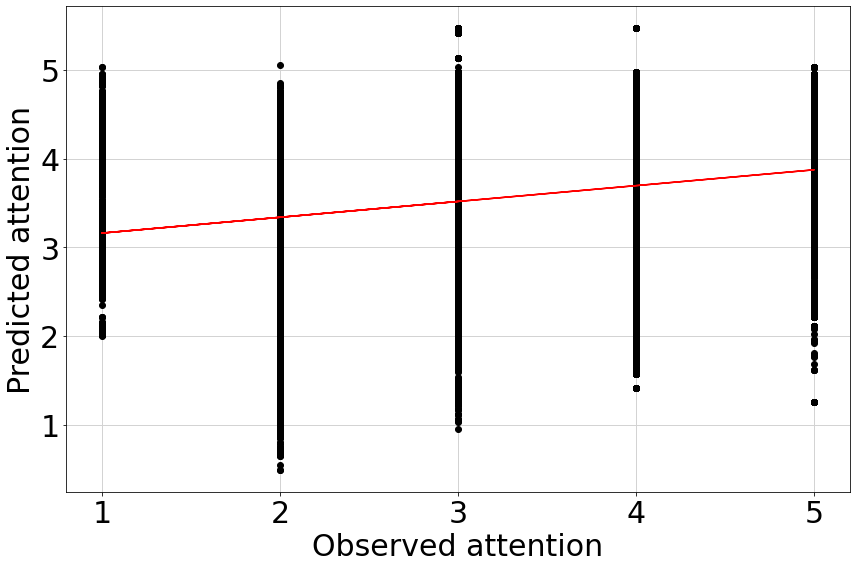

<Figure size 864x576 with 0 Axes>

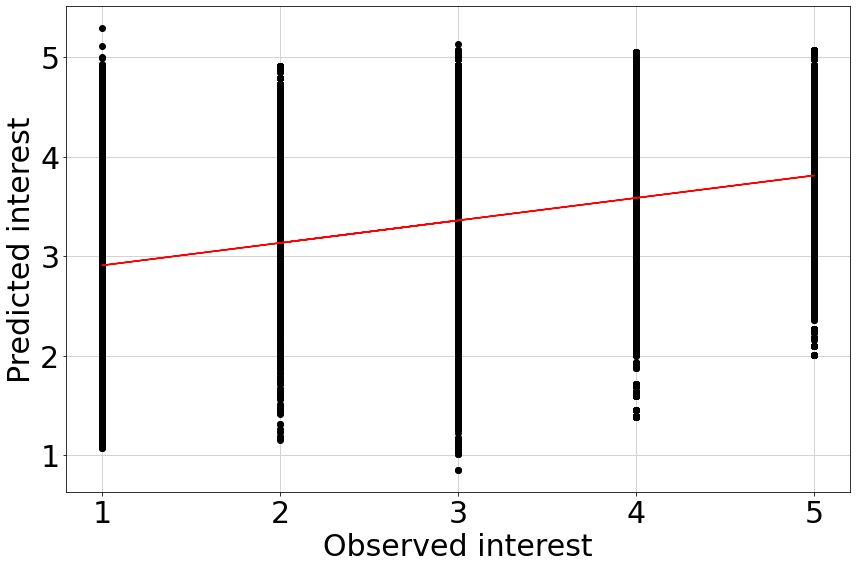

<Figure size 864x576 with 0 Axes>

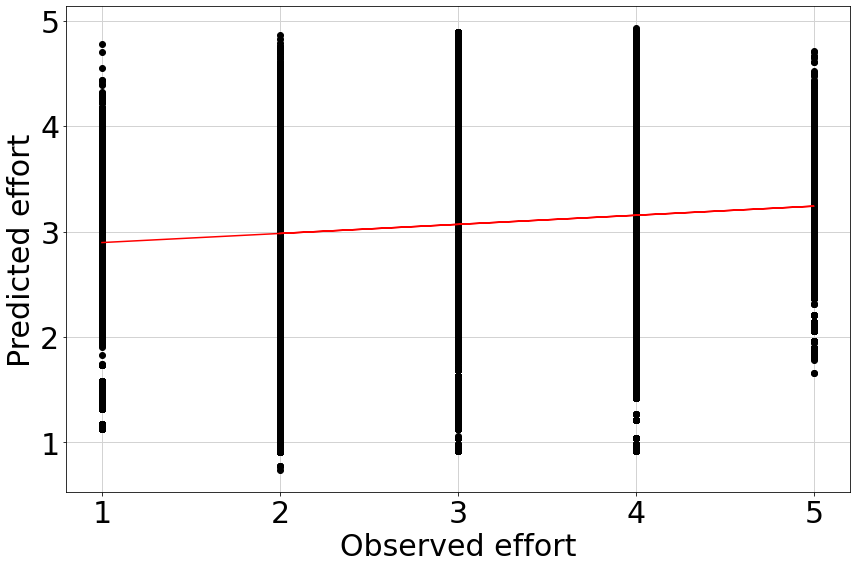

<Figure size 864x576 with 0 Axes>

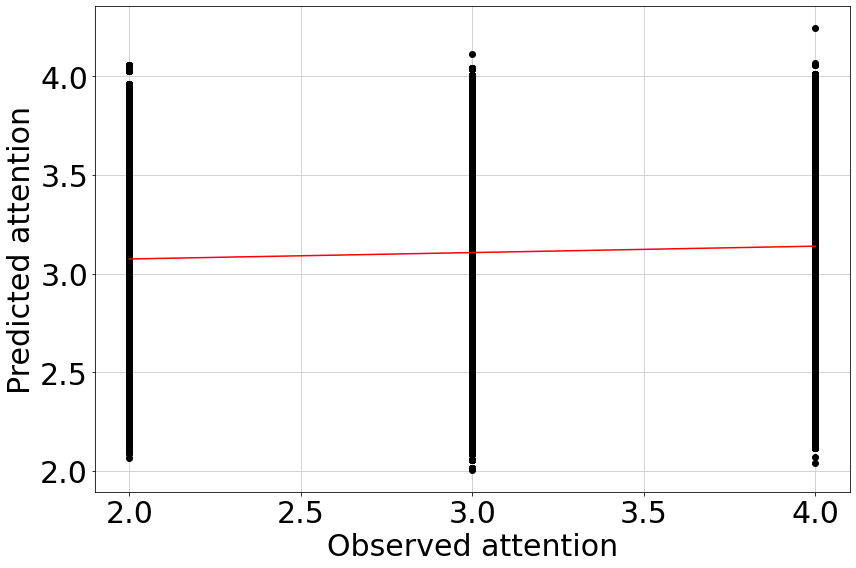

<Figure size 864x576 with 0 Axes>

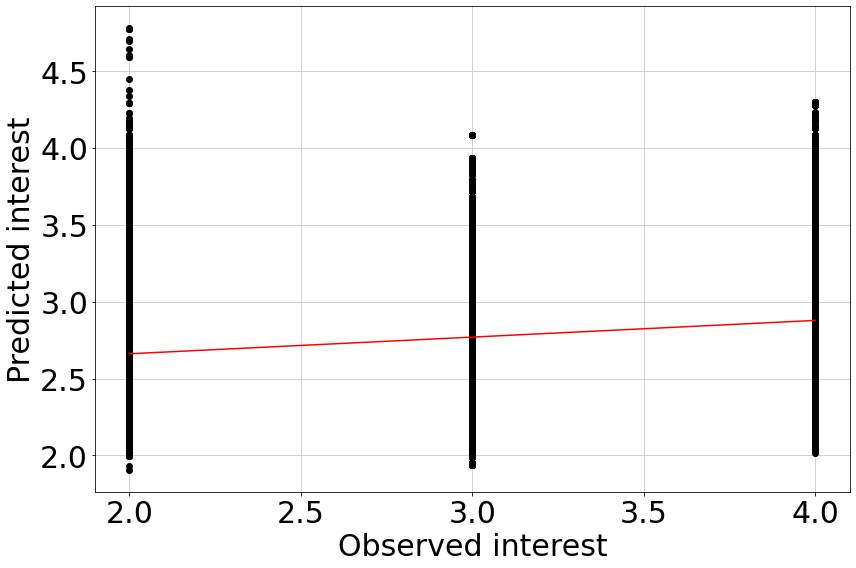

<Figure size 864x576 with 0 Axes>

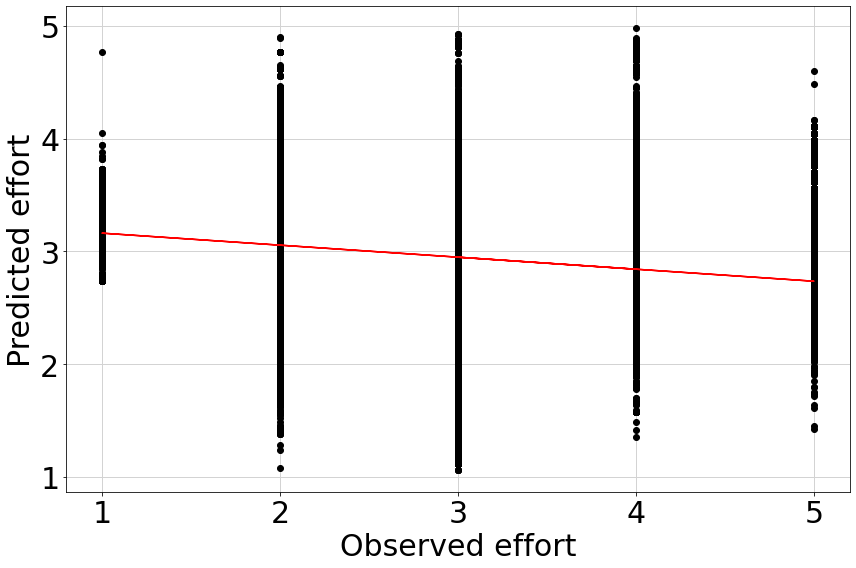

<Figure size 864x576 with 0 Axes>

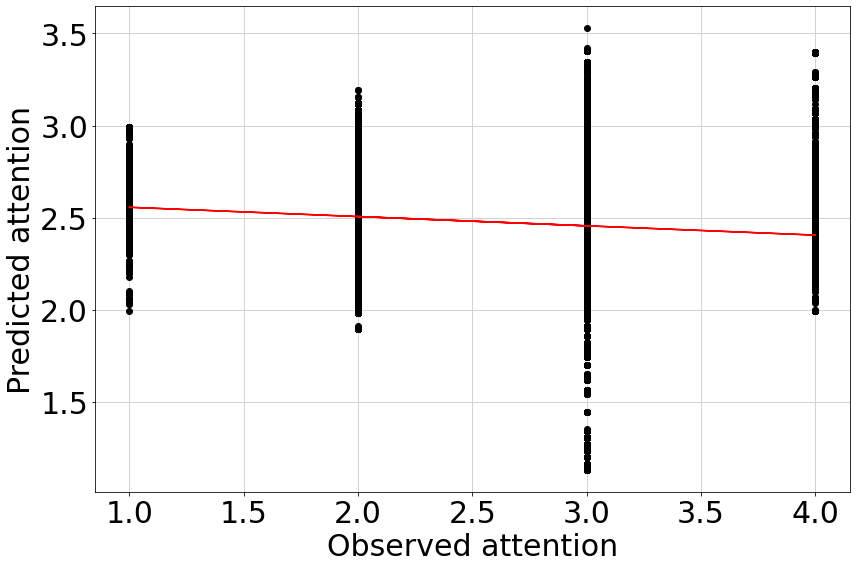

<Figure size 864x576 with 0 Axes>

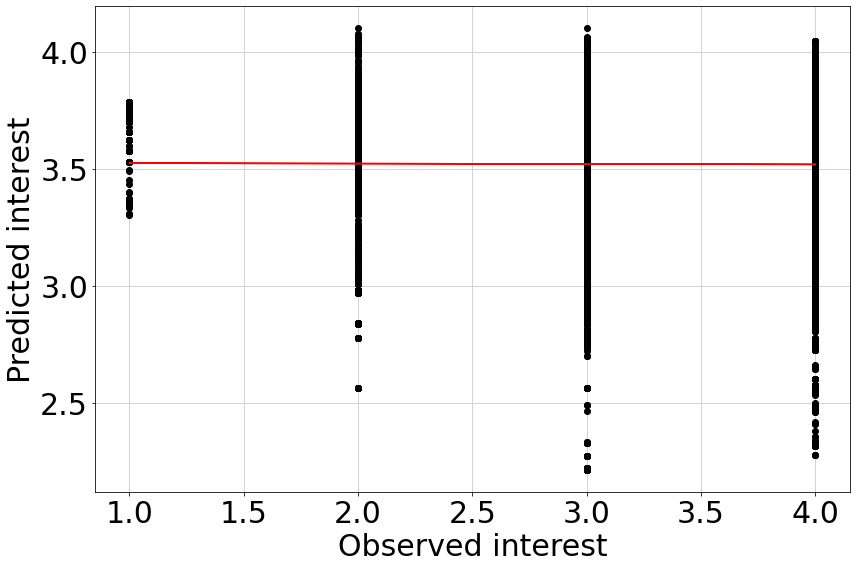

<Figure size 864x576 with 0 Axes>

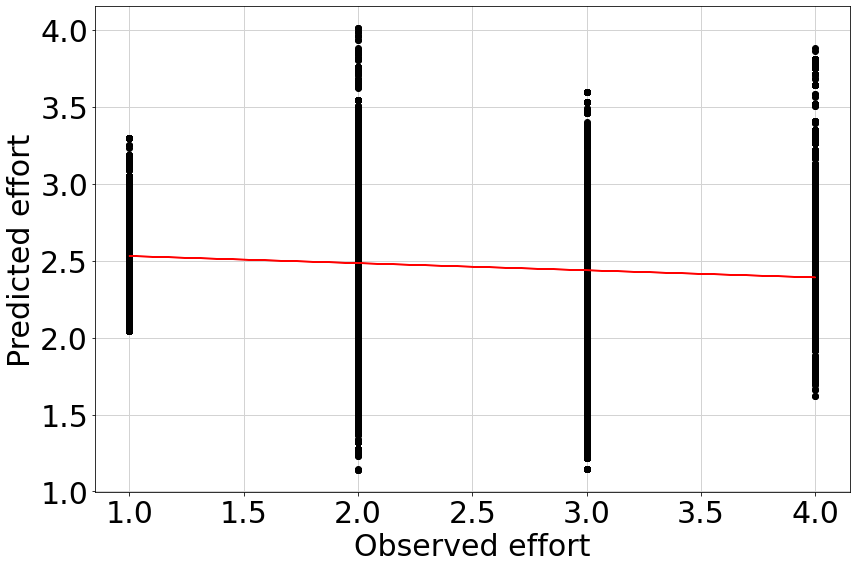

<Figure size 864x576 with 0 Axes>

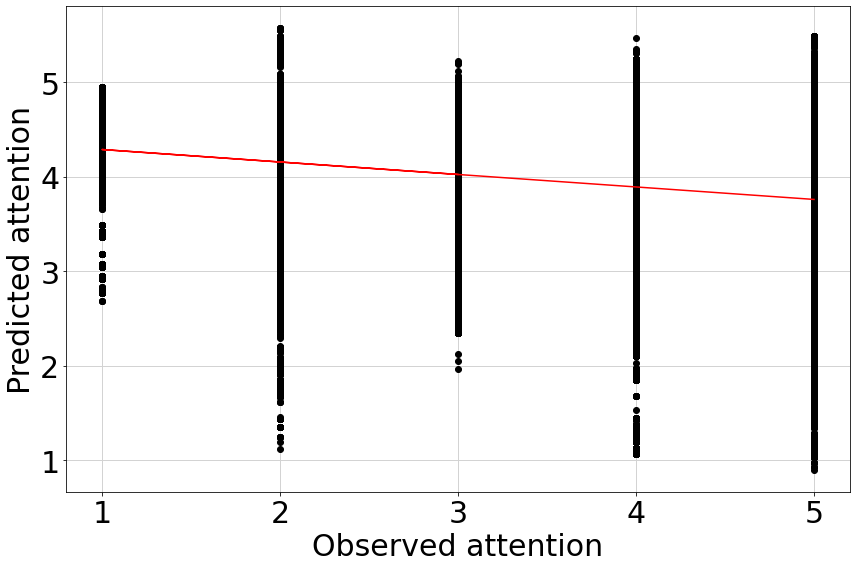

<Figure size 864x576 with 0 Axes>

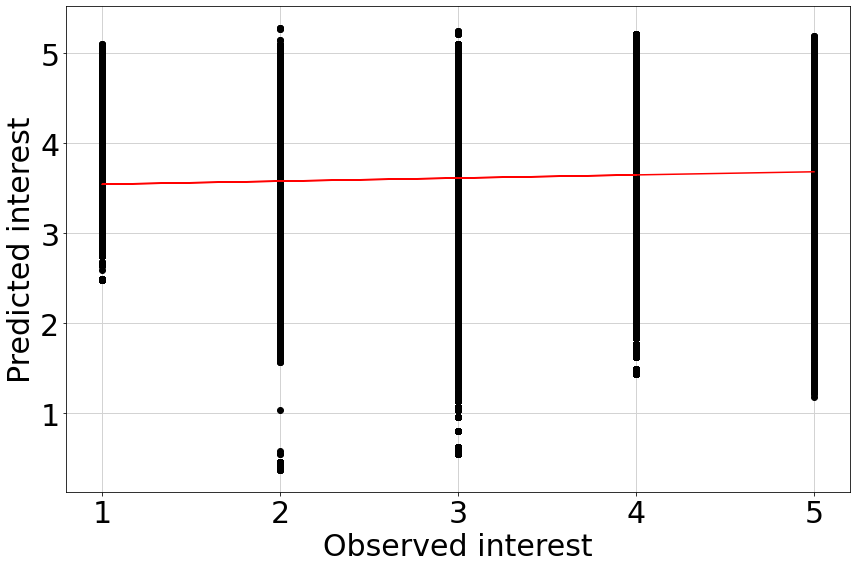

<Figure size 864x576 with 0 Axes>

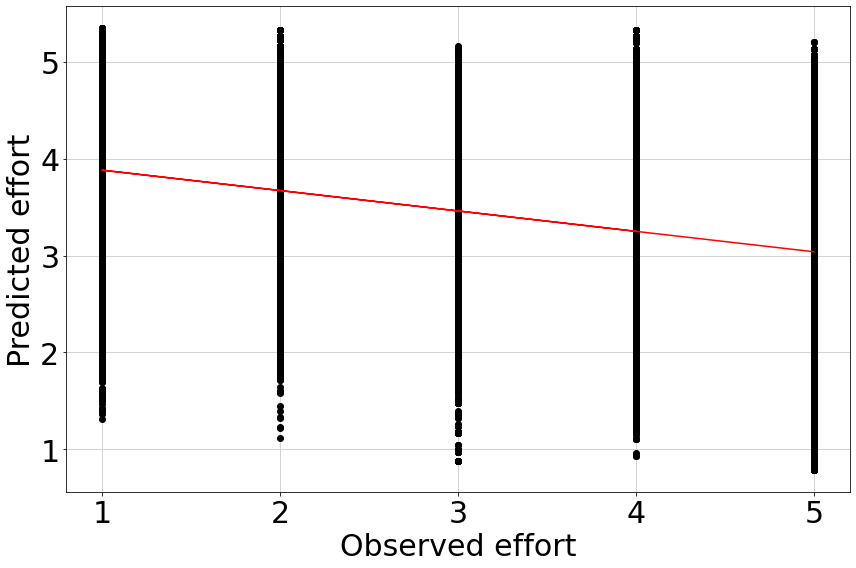

<Figure size 864x576 with 0 Axes>

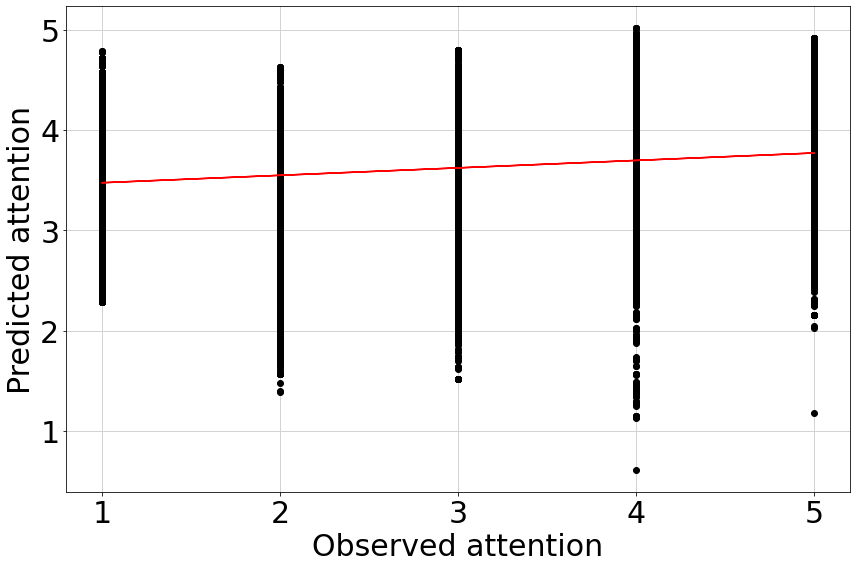

<Figure size 864x576 with 0 Axes>

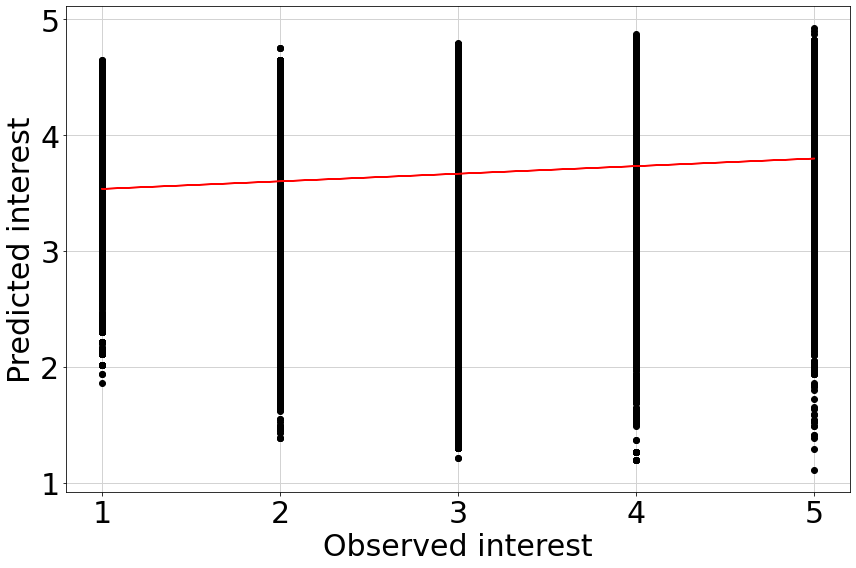

<Figure size 864x576 with 0 Axes>

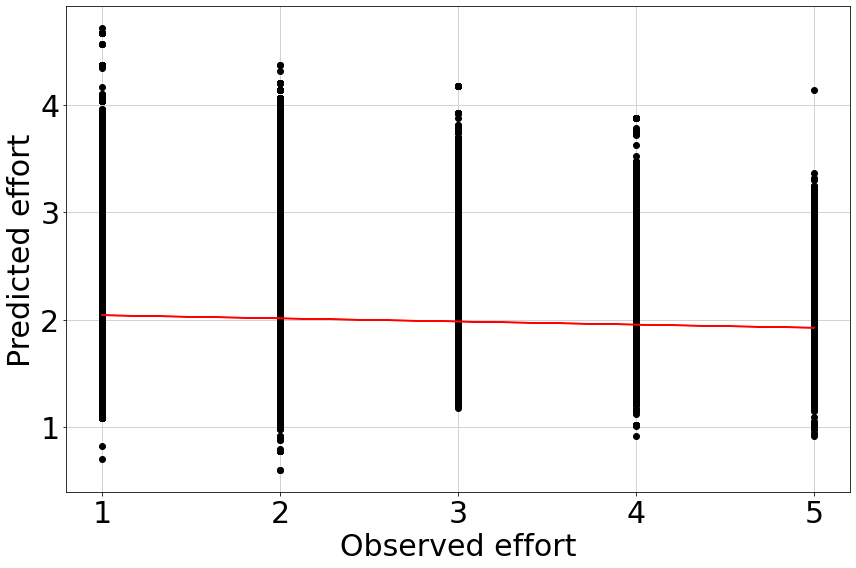

<Figure size 864x576 with 0 Axes>

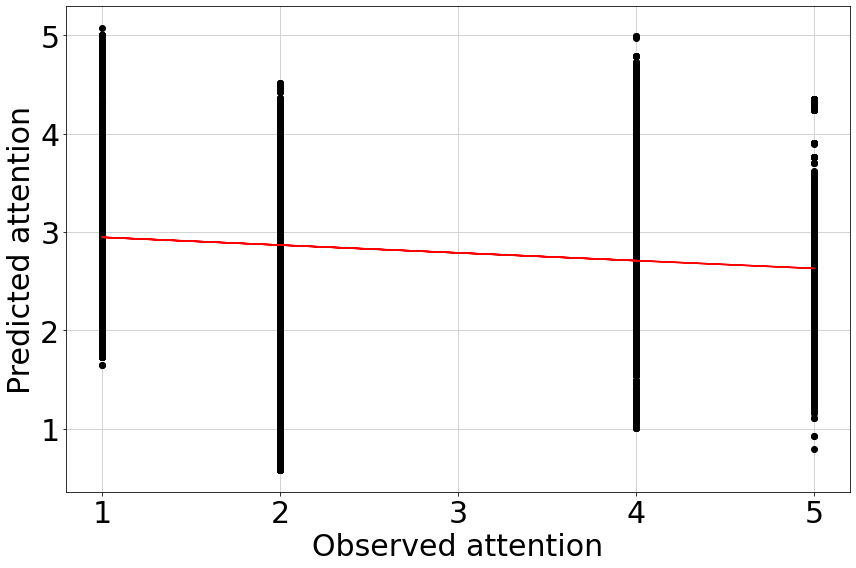

<Figure size 864x576 with 0 Axes>

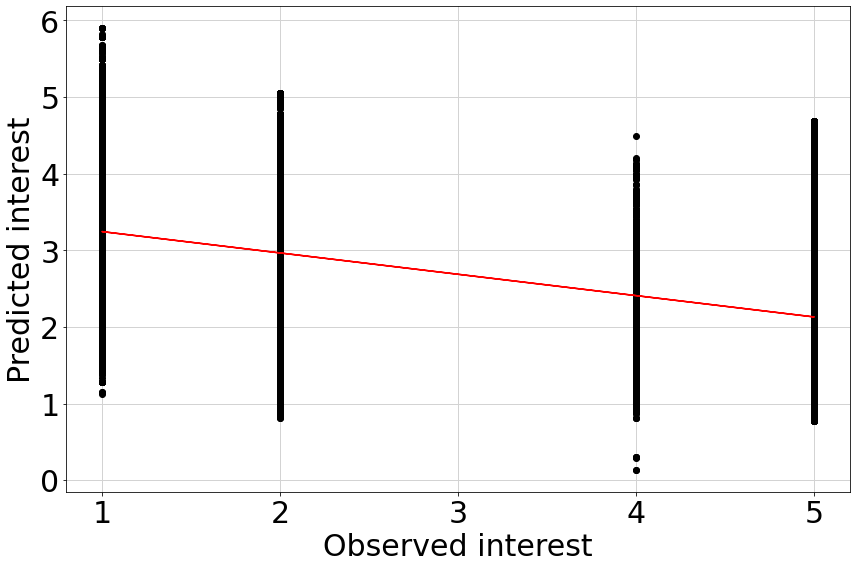

<Figure size 864x576 with 0 Axes>

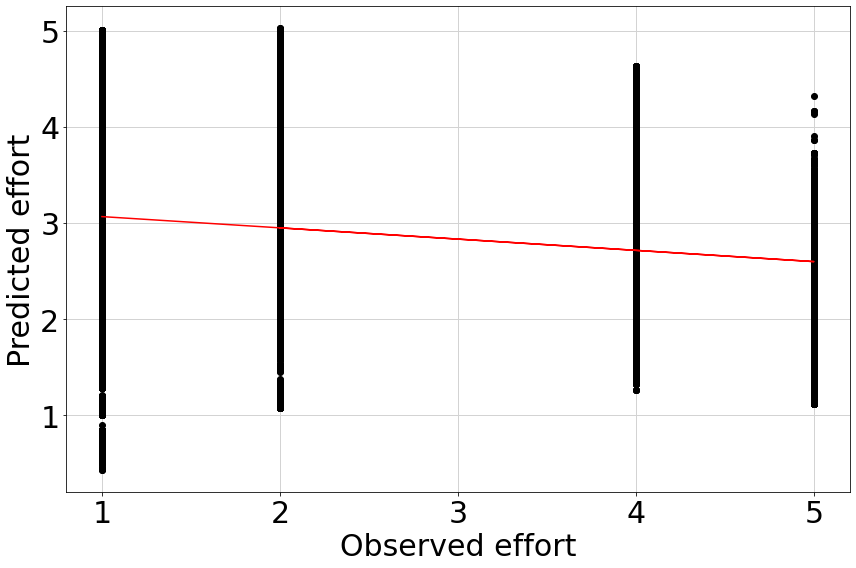

<Figure size 864x576 with 0 Axes>

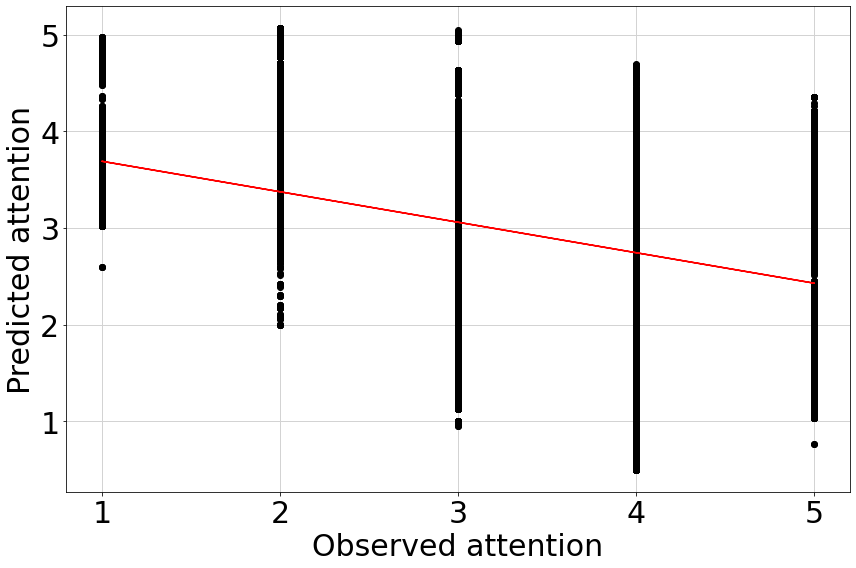

<Figure size 864x576 with 0 Axes>

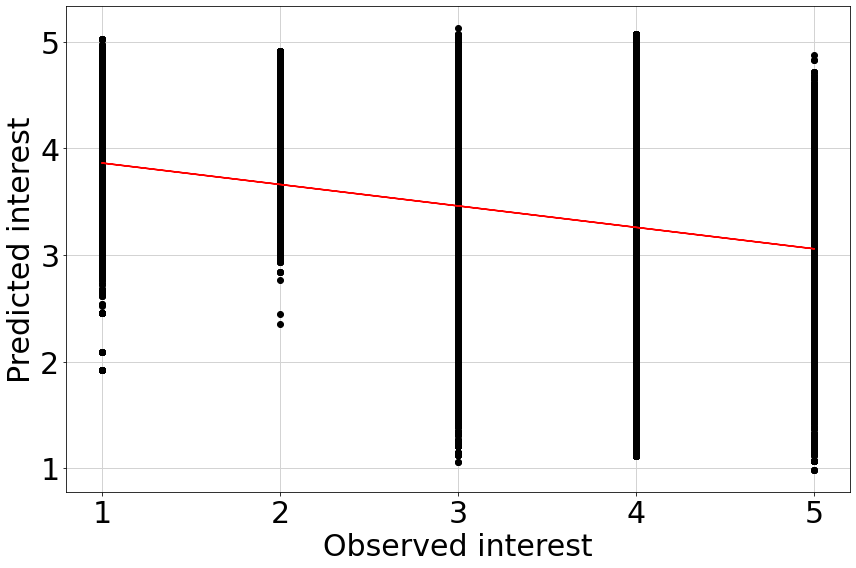

<Figure size 864x576 with 0 Axes>

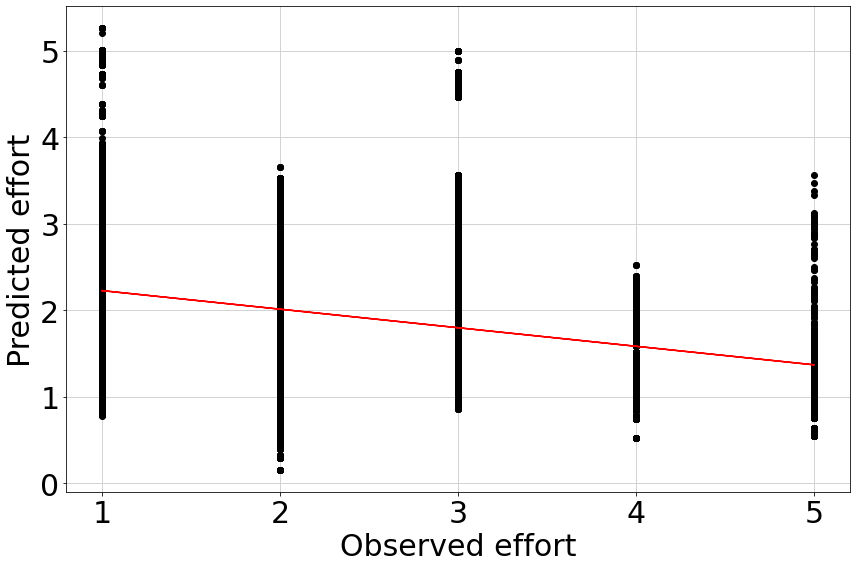

<Figure size 864x576 with 0 Axes>

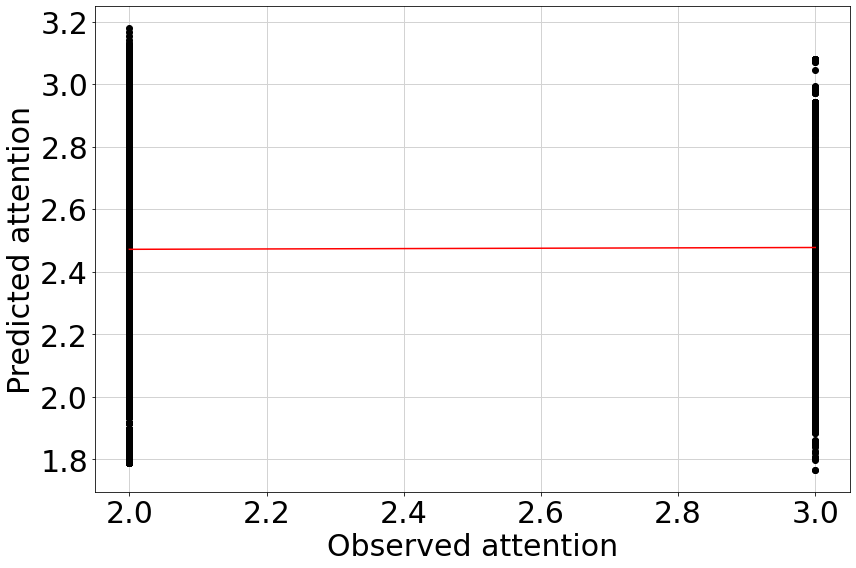

<Figure size 864x576 with 0 Axes>

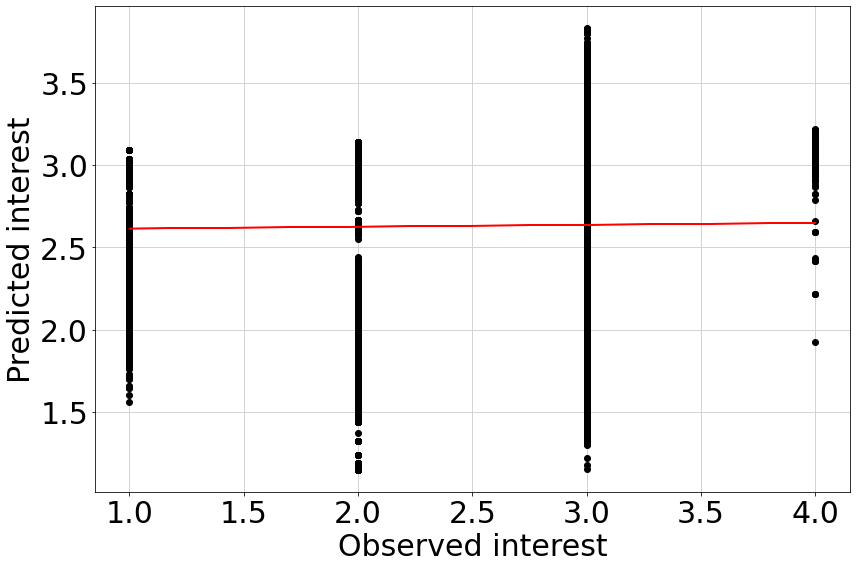

<Figure size 864x576 with 0 Axes>

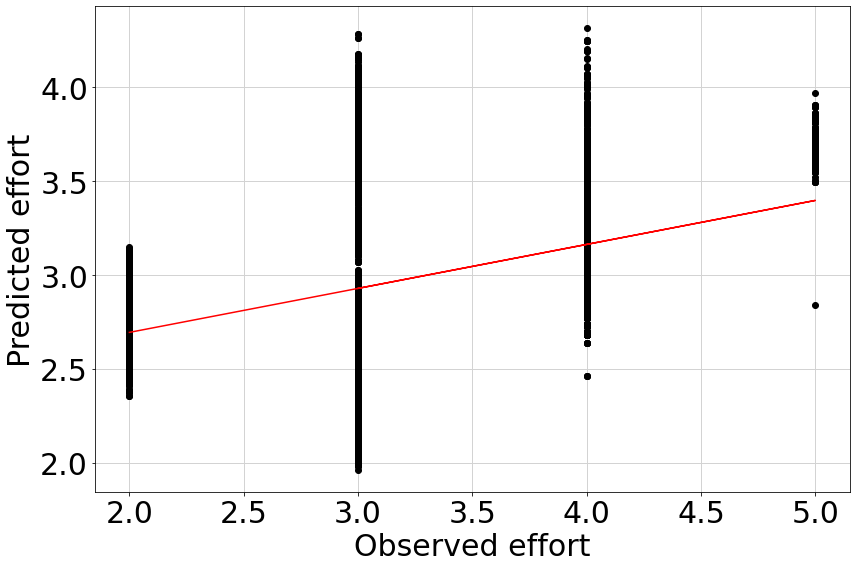

<Figure size 864x576 with 0 Axes>

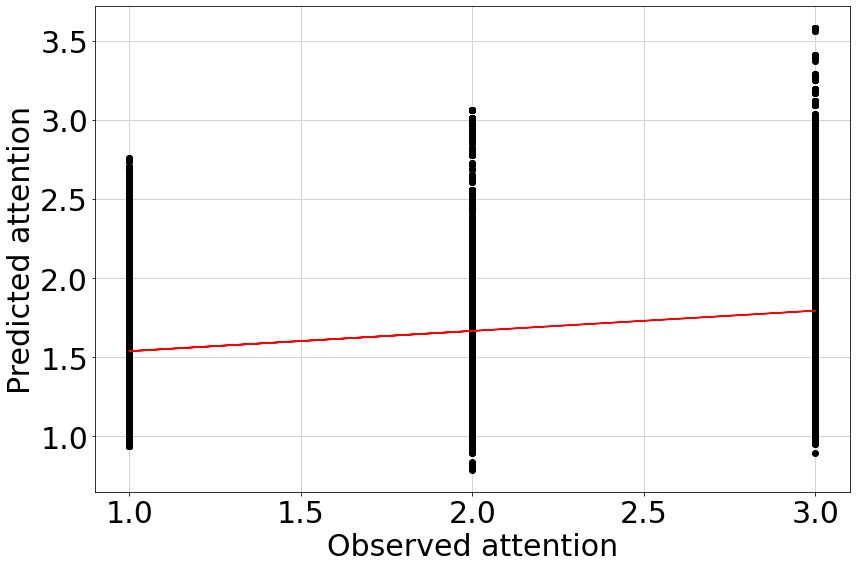

<Figure size 864x576 with 0 Axes>

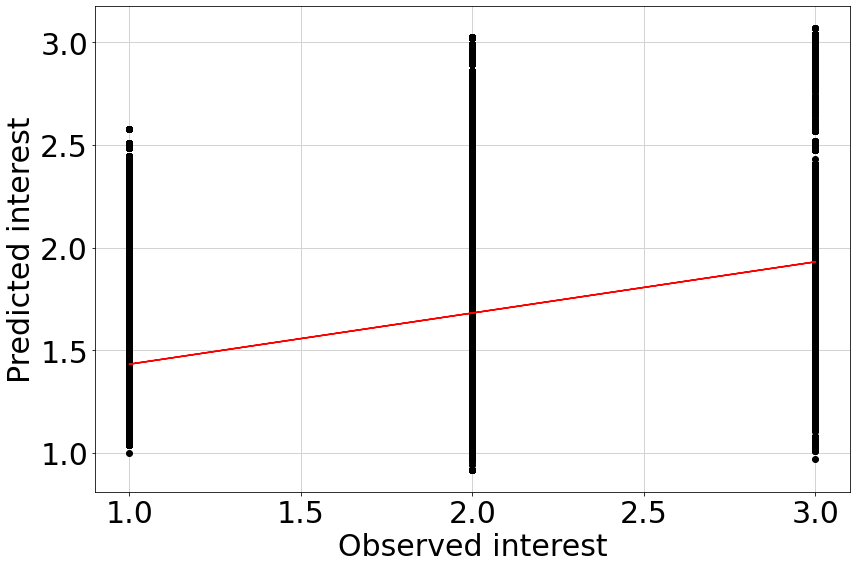

<Figure size 864x576 with 0 Axes>

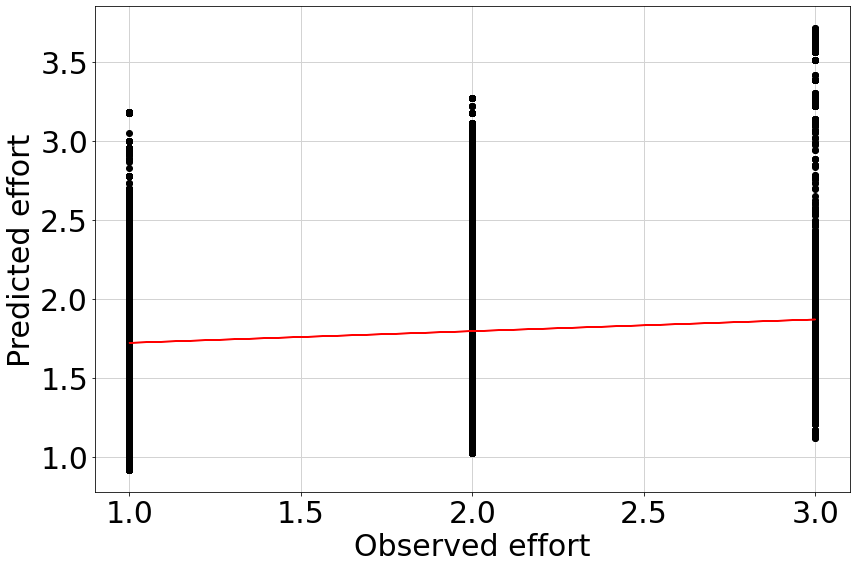

<Figure size 864x576 with 0 Axes>

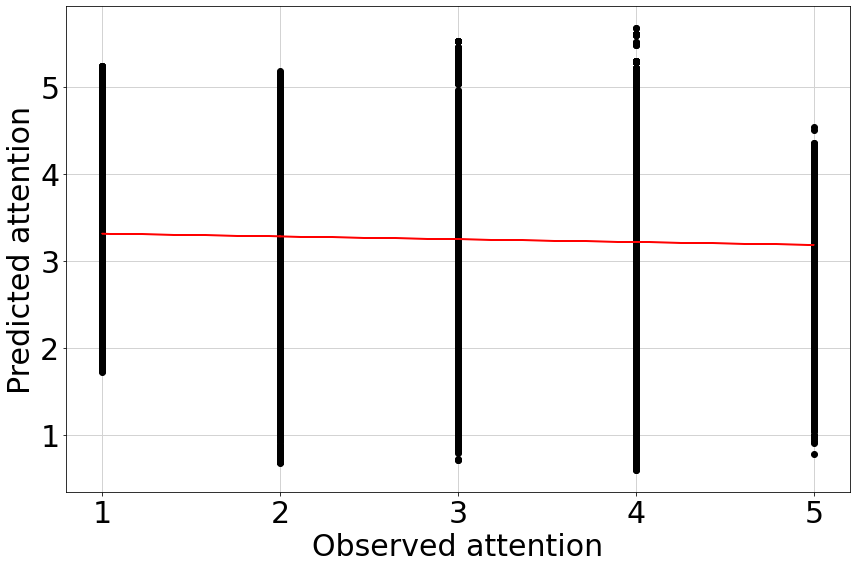

<Figure size 864x576 with 0 Axes>

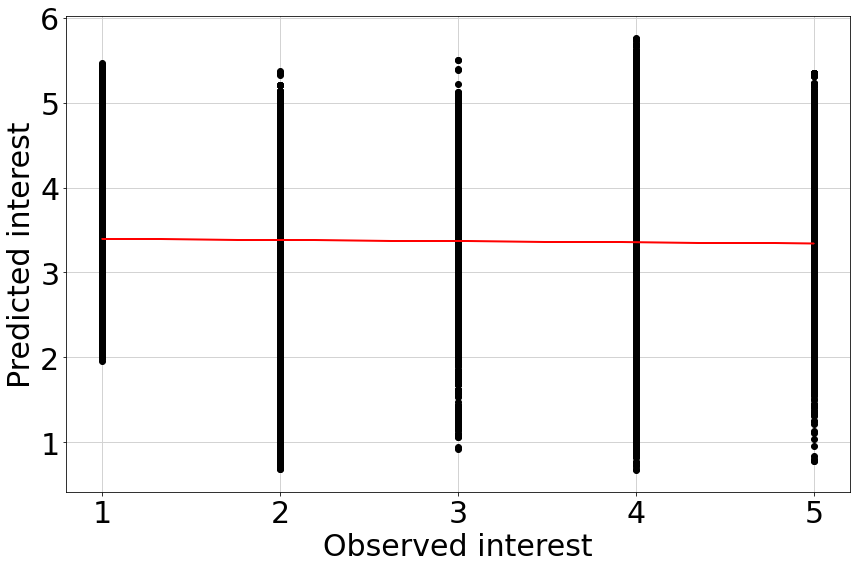

<Figure size 864x576 with 0 Axes>

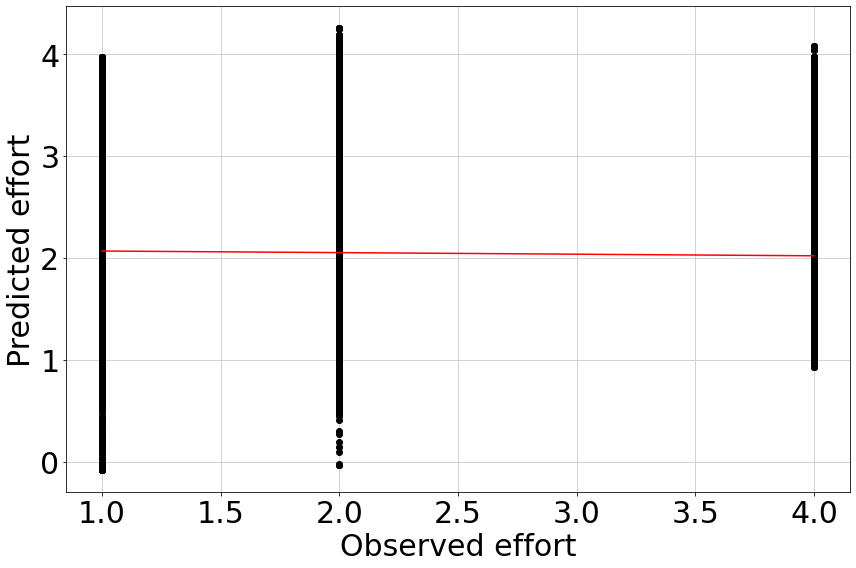

<Figure size 864x576 with 0 Axes>

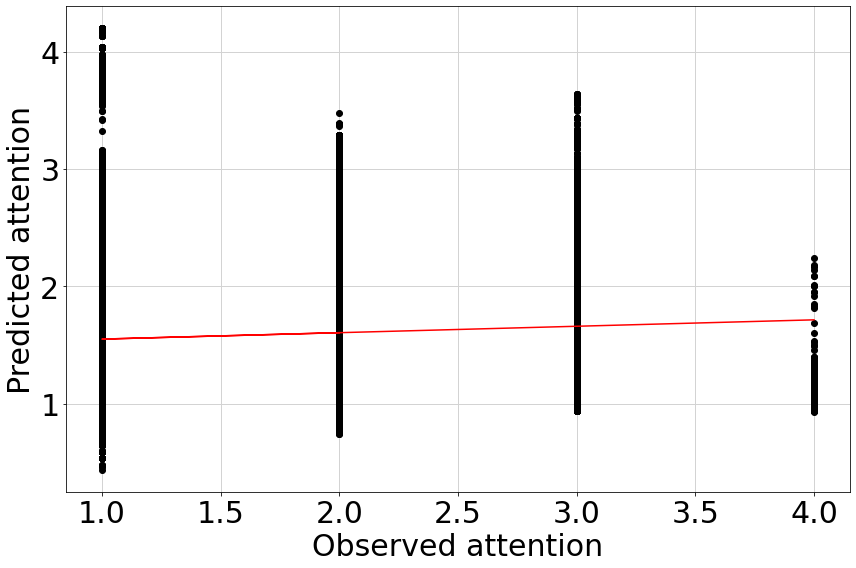

<Figure size 864x576 with 0 Axes>

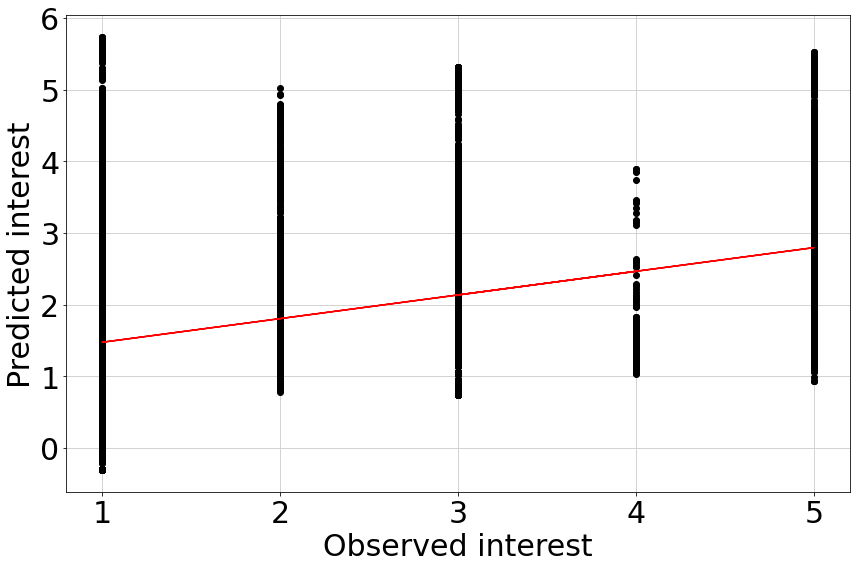

<Figure size 864x576 with 0 Axes>

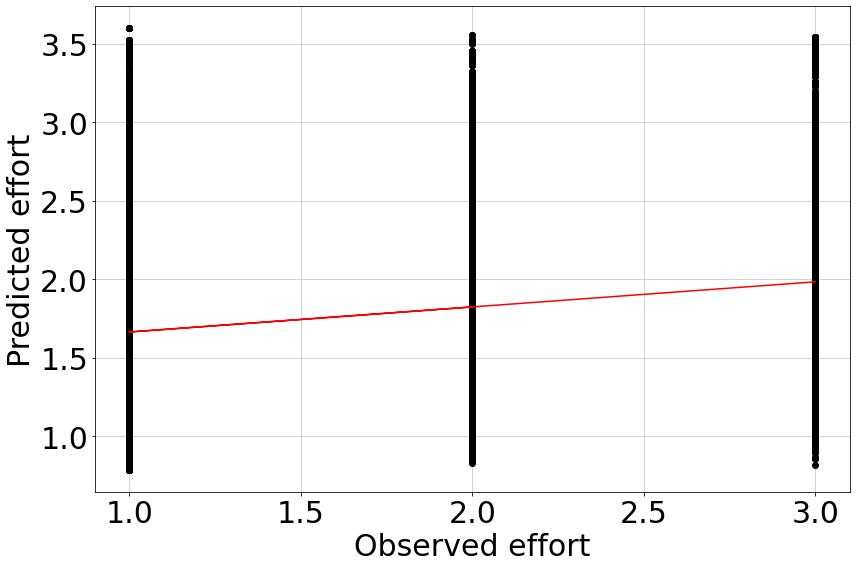

<Figure size 864x576 with 0 Axes>

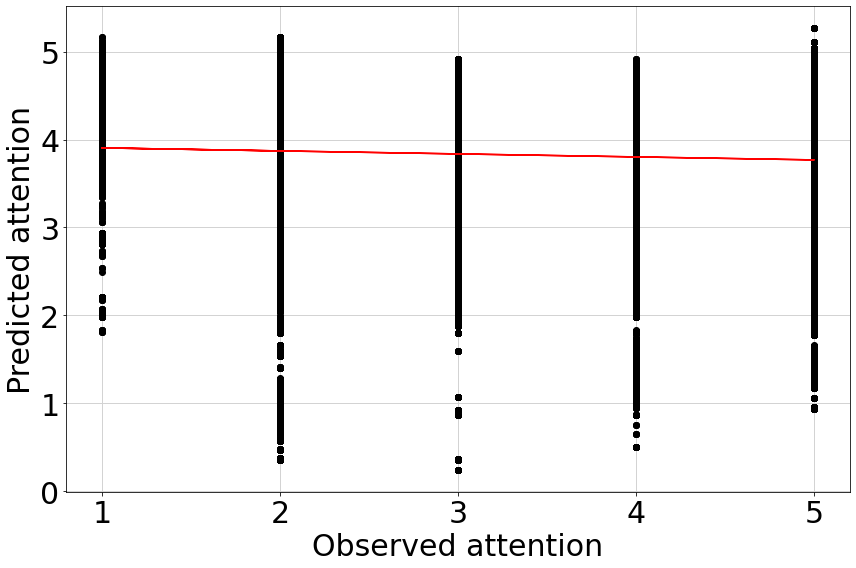

<Figure size 864x576 with 0 Axes>

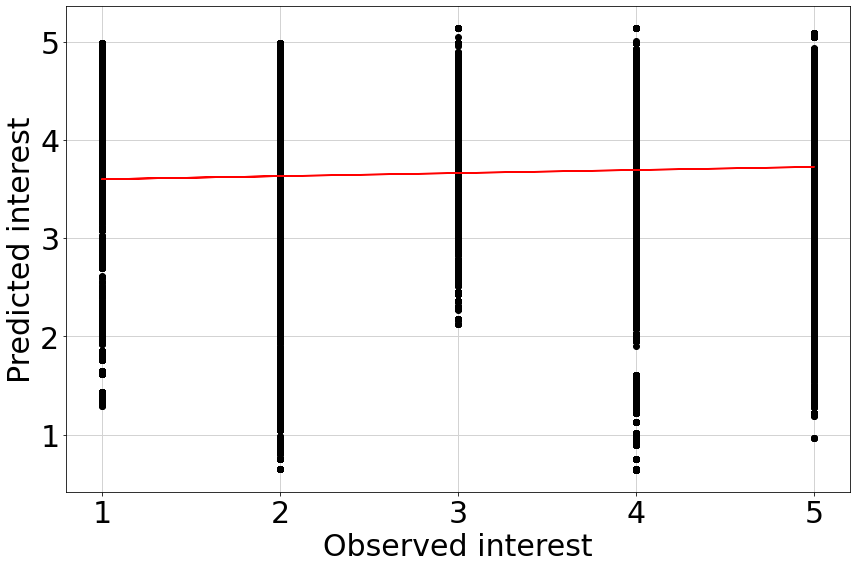

<Figure size 864x576 with 0 Axes>

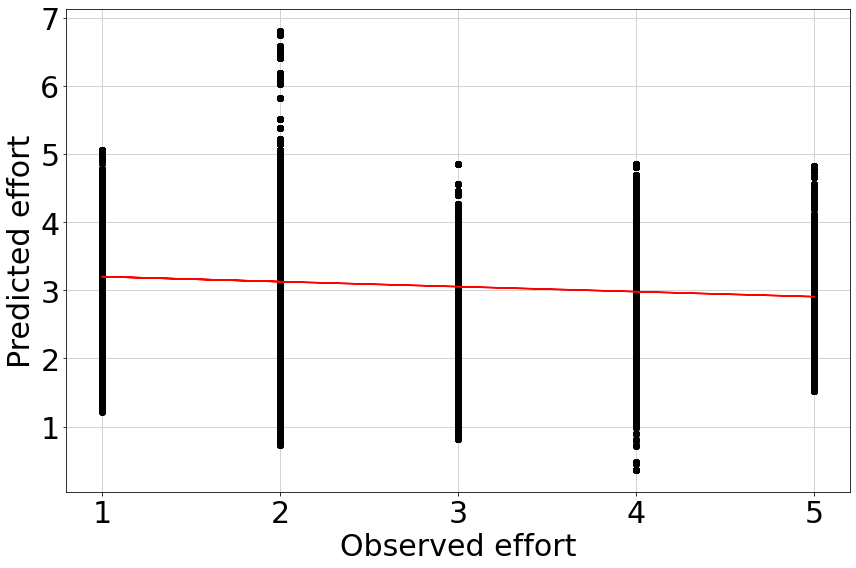

<Figure size 864x576 with 0 Axes>

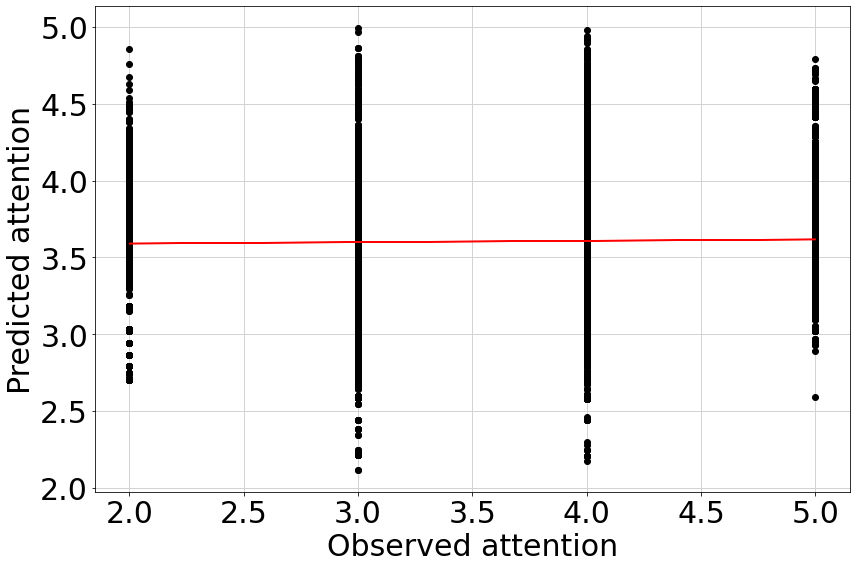

<Figure size 864x576 with 0 Axes>

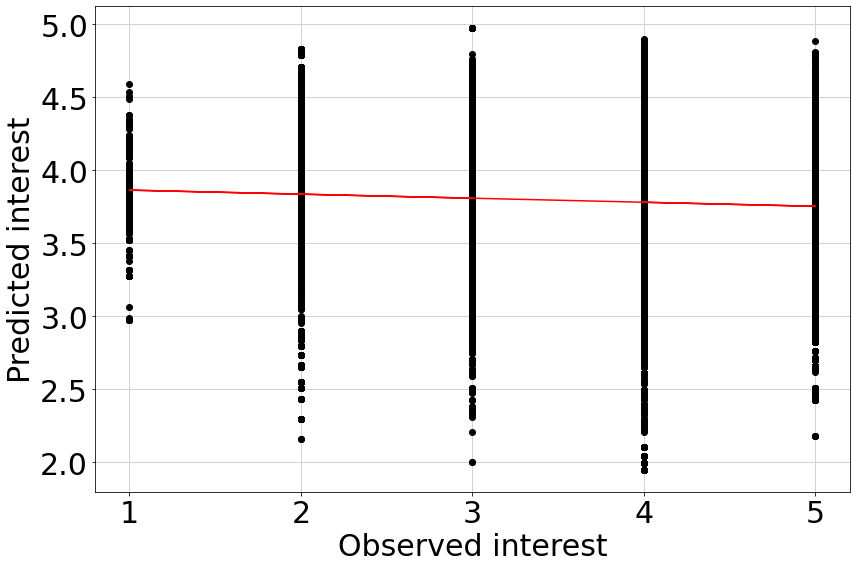

<Figure size 864x576 with 0 Axes>

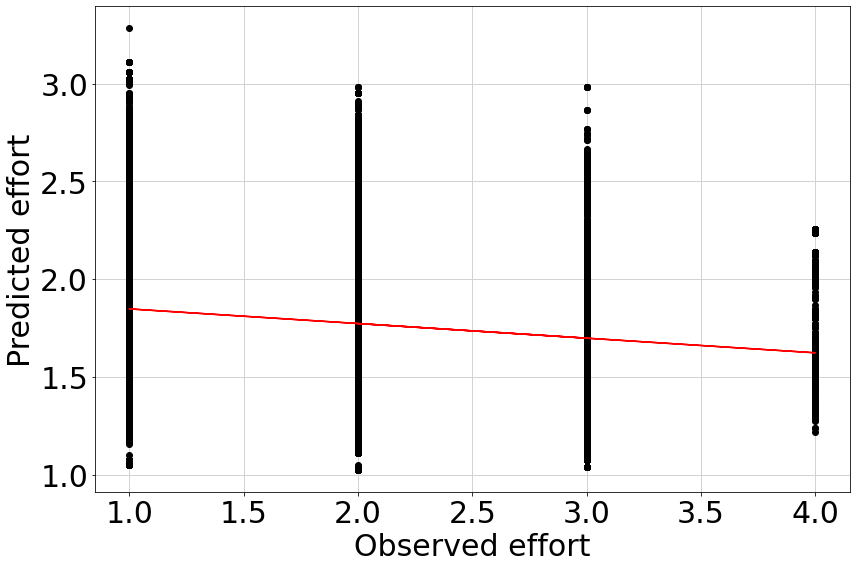

<Figure size 864x576 with 0 Axes>

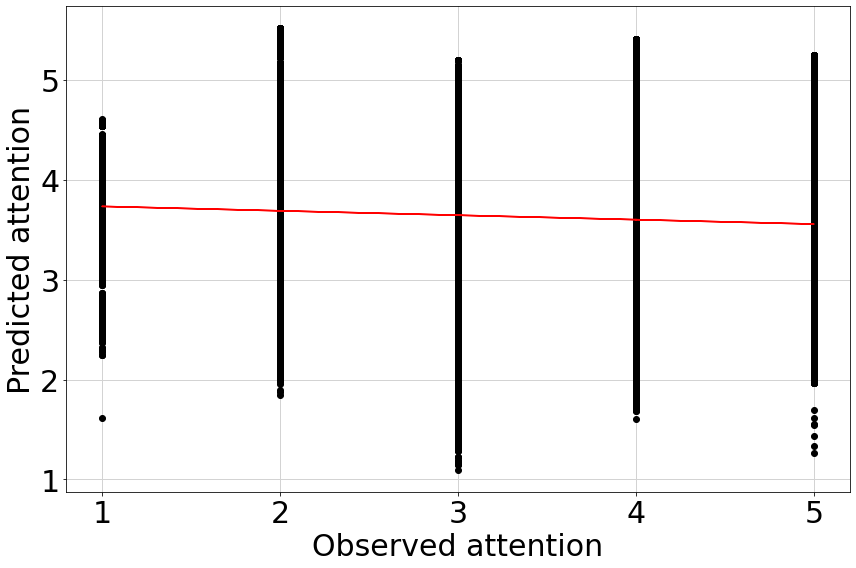

<Figure size 864x576 with 0 Axes>

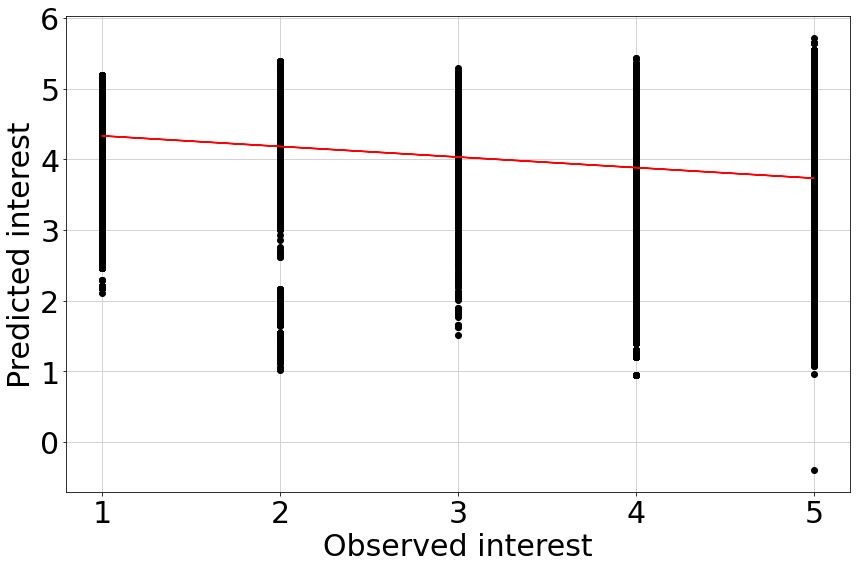

<Figure size 864x576 with 0 Axes>

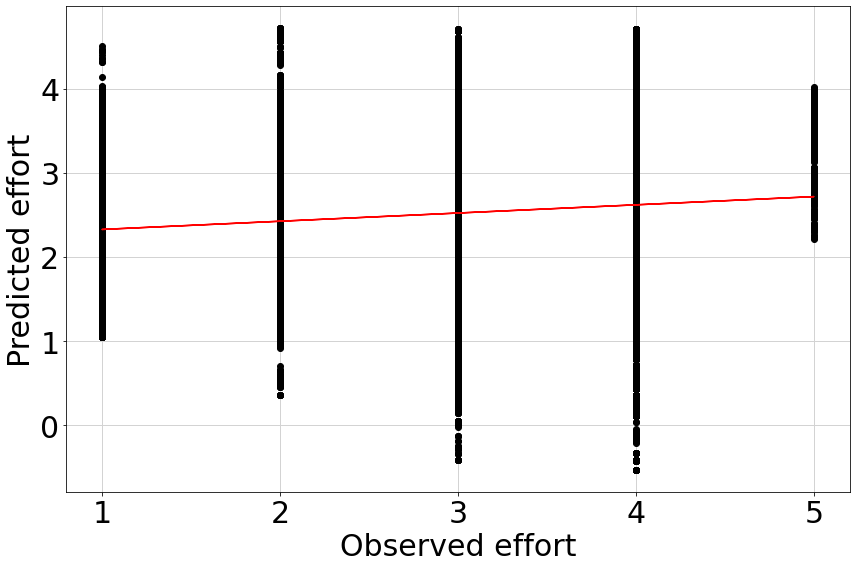

<Figure size 864x576 with 0 Axes>

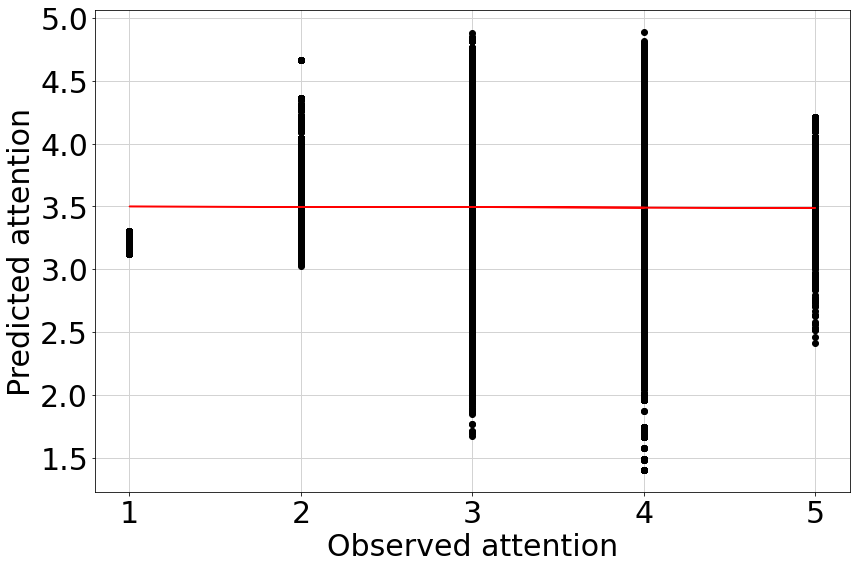

<Figure size 864x576 with 0 Axes>

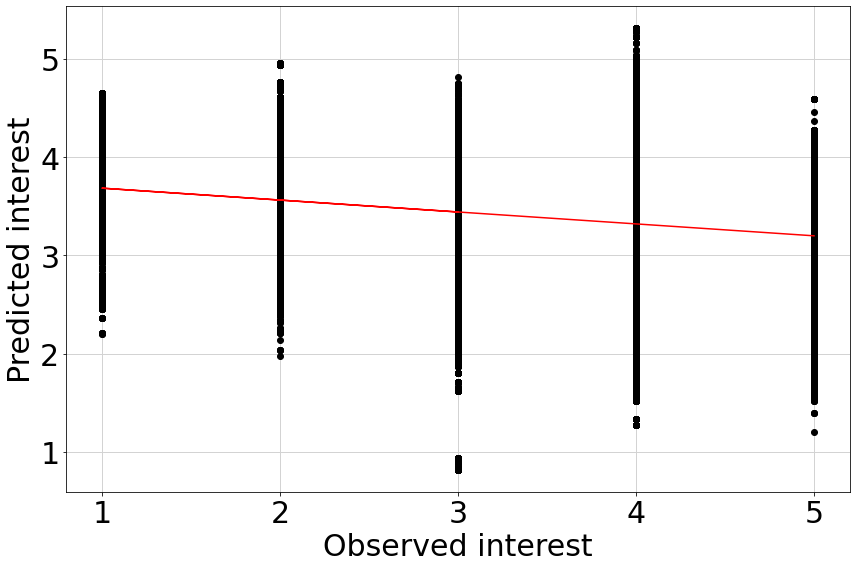

<Figure size 864x576 with 0 Axes>

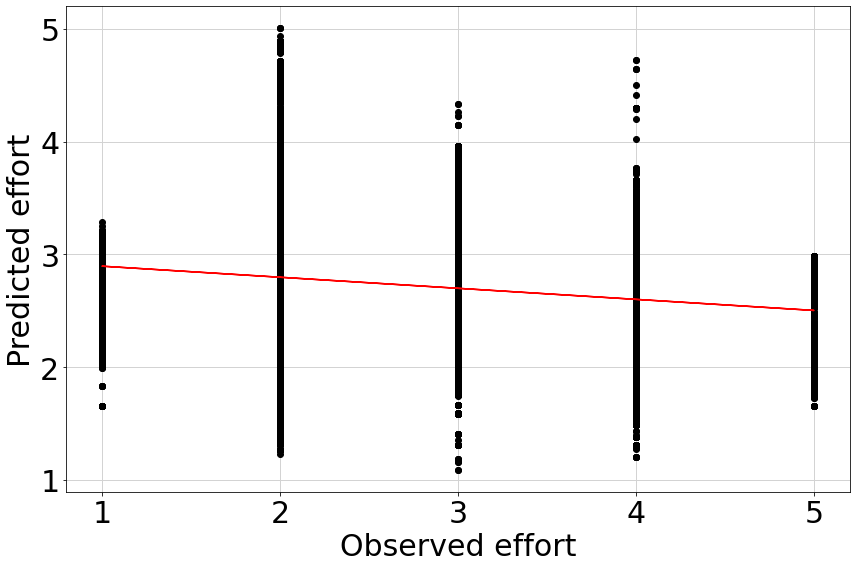

<Figure size 864x576 with 0 Axes>

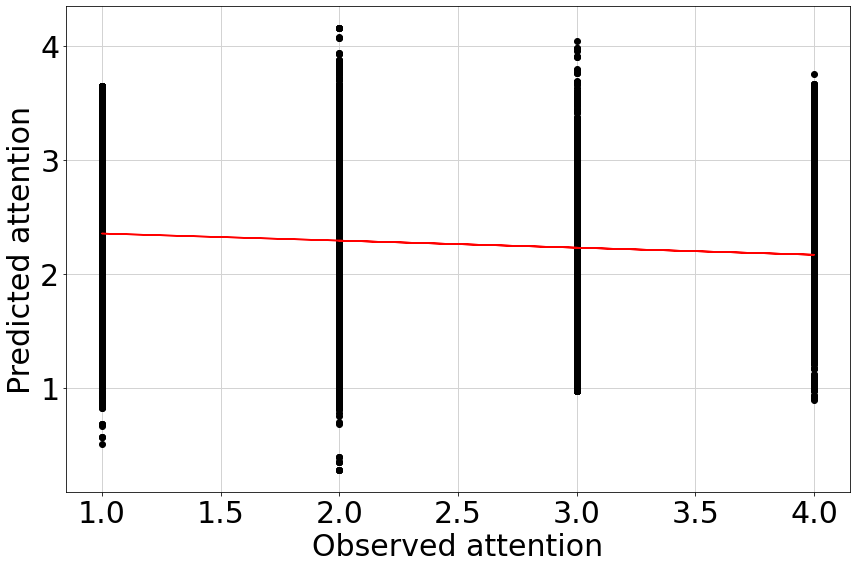

<Figure size 864x576 with 0 Axes>

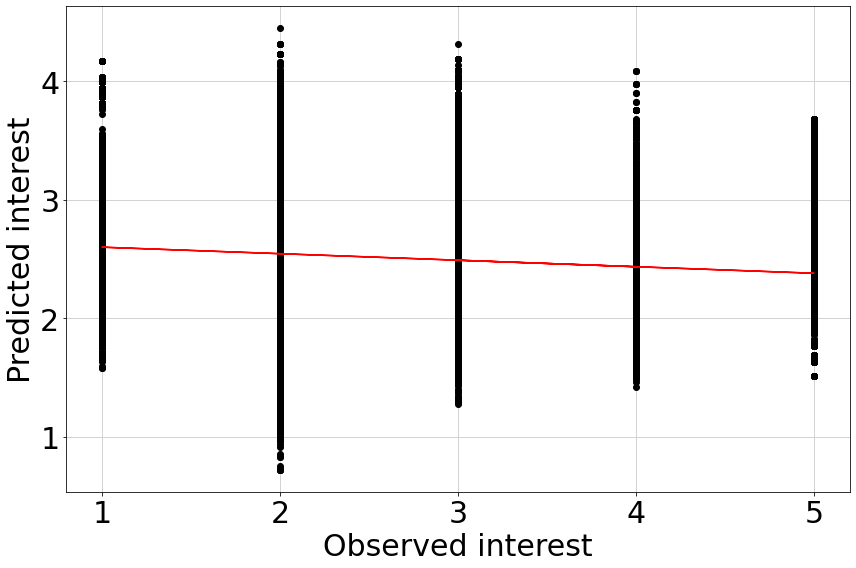

<Figure size 864x576 with 0 Axes>

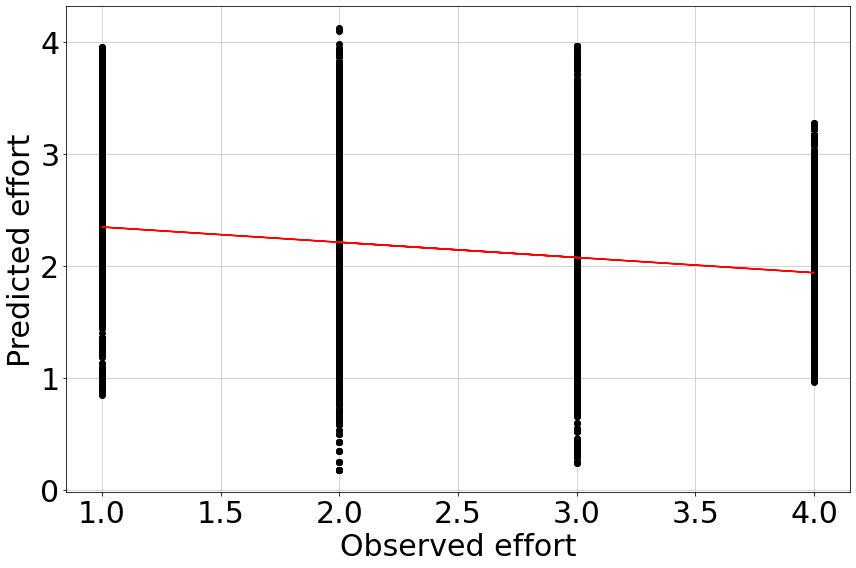

In [8]:
r = get_all_results('reg', 'per user')

Time elapsed! 88.33137512207031


<Figure size 864x576 with 0 Axes>

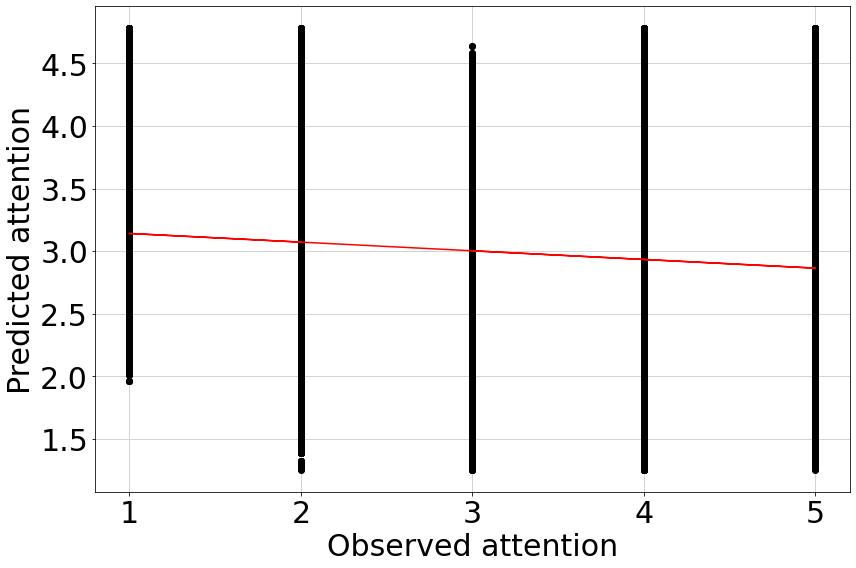

<Figure size 864x576 with 0 Axes>

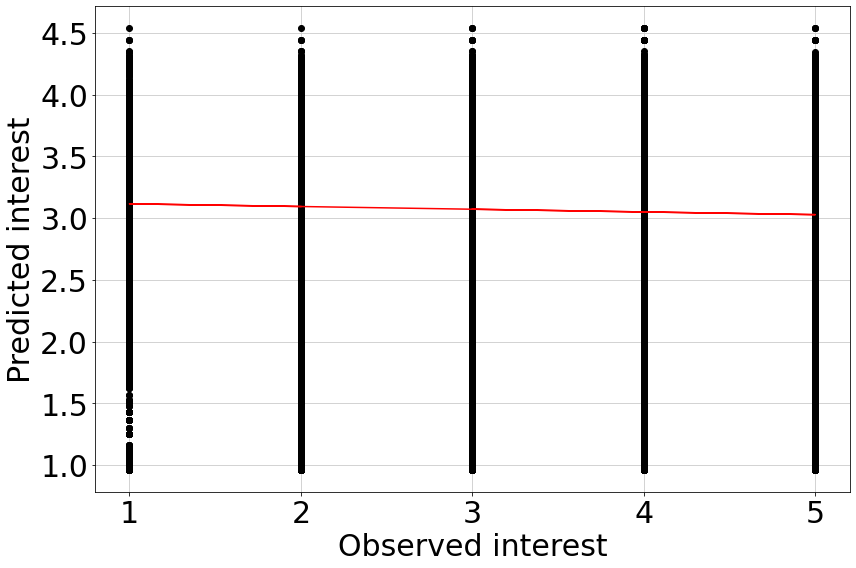

<Figure size 864x576 with 0 Axes>

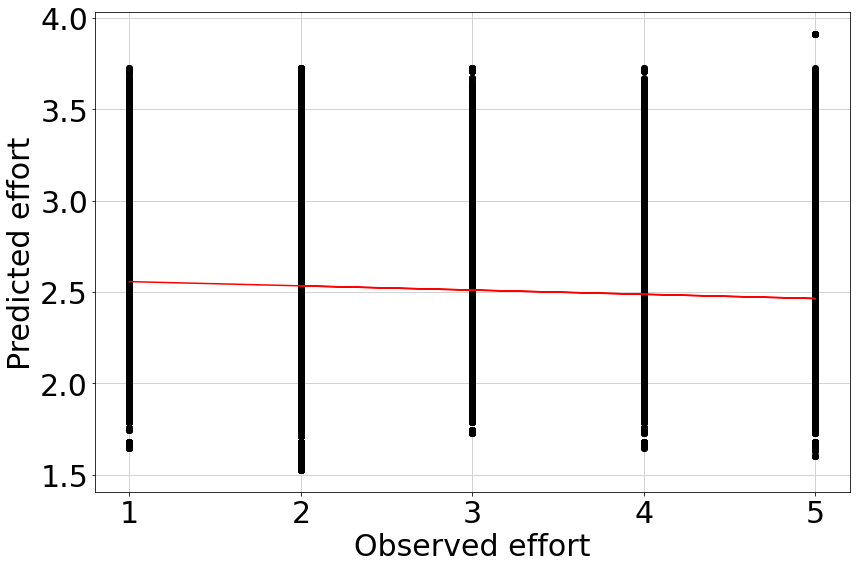

In [9]:
r = get_all_results('reg', 'cross user')